# Exam Jupyter Notebook

## Introduction

In general, we are dealing with elements in lists within a list (a list of documents consisting of lists of words). 

Hence, we make use of the following steps to process our data.

* Step 1: define a function for a "specific" case
* Step 2: use the the function to loop through all the cases

Note that we do not document lambda functions.

Notable abbreviations:
* GEC, Greenland Economic Council 
* POB, Ministry of Finance (Politisk-Økonomisk Årsberetning)

## Import

In [3]:
from prettytable import PrettyTable 
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from nltk.util import ngrams
import urllib.request
import pandas as pd
import requests
import string
import PyPDF2
import shutil
import lemmy
import os

## Get URL

In [4]:
# url function (f-string method)
get_url = lambda year: f'https://naalakkersuisut.gl/~/media/Nanoq/Files/Attached%20Files/Finans/DK/Oekonomisk%20raad/GOR_ny/G%C3%98R%20rapport%20{year}%20da.pdf'

# GEC
GEC_urls = [get_url(year) for year in range(2015, 2019+1)]   
GEC_urls.append("https://naalakkersuisut.gl/~/media/Nanoq/Files/Attached%20Files/Finans/DK/Oekonomisk%20raad/GOR_ny/GR%2020205%20Forrsrapport%20%20da.pdf") # odd case

# POB (manual)
pob_path = "https://naalakkersuisut.gl/~/media/Nanoq/Files/Attached%20Files/Finans/DK/Politisk%20Oekonomisk%20Beretning/"
pob2020  = pob_path + "P%C3%98B2020%20final%20DK.pdf"
pob2019  = pob_path + "P%C3%98B2019%20DK.pdf"
pob2017  = pob_path + "POB%202017%20dansk%20web%20final%202017_05_08.pdf"
pob2016  = pob_path + "POB_materie_FINAL_DK_2016_3korr.pdf"
pob2015  = pob_path + "POB_2015_Final_DK.pdf"
pob2014  = pob_path + "POB%202014%20INT%20DK.pdf"
pob2012  = pob_path + "10-FM2012-P%C3%98B-Naal%20for%20Finanser-dk.pdf"
pob2011  = pob_path + "PB%202011%20DK%20Final%20endelig%2014032011.pdf"
pob2010  = pob_path + "P%C3%98B%20DK%202010%20Final.pdf"

POB_urls = [pob2020, pob2019, pob2017, pob2016, pob2015, pob2014, pob2012, pob2011, pob2010]

## Download PDF

In [5]:
# download function (with request)
def download_files(download_url, filename):
    """
    Downloads pdf from the internet. 
    Note that the code is just copy paste from the internet (except this docstring).
    """
    response = urllib.request.urlopen(download_url)    
    file = open(filename + ".pdf", 'wb')
    file.write(response.read())
    file.close()

# GEC 
GEC_years = [str(year) for year in range(2015, 2020+1)]
GEC_pubs  = ["GEC" + str(i) for i in GEC_years]

for url, pub in zip(GEC_urls, GEC_pubs): download_files(url, str(pub))
    
# POB
POB_years = [str(year) for year in range(2010, 2020+1) if year not in [2013, 2018]] # pub 2013 and 2018 not available
POB_pubs  = ["POB" + str(year) for year in POB_years[::-1]] # reverting list according to order of filenames

for url, pub in zip(POB_urls, POB_pubs): download_files(url, str(pub))

## Read PDF

In [6]:
# pdf reader function
pdf_reader = PyPDF2.PdfFileReader

# GEC
GEC_files = [pub + ".pdf" for pub in GEC_pubs]
GEC_pdfs  = [pdf_reader(pdf) for pdf in GEC_files]

# POB
POB_files = [pub + ".pdf" for pub in POB_pubs]
POB_pdfs  = [pdf_reader(pdf) for pdf in POB_files]

## PDF as string

In [7]:
# pdf to string function
def pdf2string(pdf):
    """
    Fills empty string with text from each page in pdf
    """
    text = ""
    for page in range(1, pdf.getNumPages()):
        text += pdf.getPage(page).extractText()
    return text

# GEC
GEC_texts = [pdf2string(pdf) for pdf in GEC_pdfs]

# POB
POB_texts = [pdf2string(pdf) for pdf in POB_pdfs]

## Preprocessing

In [8]:
# split to lower function
split2lower = \
    lambda str_element:\
        str_element\
            .replace("\n", "")\
            .translate(str.maketrans('', '', string.punctuation))\
            .translate(str.maketrans('', '', string.digits))\
            .lower()\
            .split()

# list of danish stop words from github
stopWords  =\
    requests\
        .get("https://gist.githubusercontent.com/berteltorp/0cf8a0c7afea7f25ed754f24cfc2467b/raw/305d8e3930cc419e909d49d4b489c9773f75b2d6/stopord.txt")\
        .text \
        .split()

# manual removal
randomStopWords = \
    [
    'on', 'm', 'g', 'ak', '©', 
     'b', 'ﬂ–', 'ﬂ', 'fg', 'jf', 
     'npk', 'asg', 'pk', 'ken', 
     'œ', 'ffle', 'fm', 'as',
]

# manual removal
additionalStopWords = \
    [
    'samt', 'medføre',  'netop', 
     'mht', 'hidtil', 'have', 
    'tabel', 'bla', 'foreligge', 
    'vedre', 'derimod', 'kapitel', 
    'indholdsfortegnelse', 
    'sammenfatning', 'herunder', 
    'henhold', 'derimod', 'idet',  
    'inden', 'anm', 'dvs', 'desto',
]

# manual removal
stopNames = \
    [
    'torben', 'andersen', 
    'ulla', 'lynge', 
    'anders', 'møller', 'christensen', 
    'anders', 'blaabjerge', 
    'søren', 'bjerregaard', 
    'najaaraq', 'christiansen', 
    'claire', 'armstrong', 
    'brianbuus', 'pedersen', 
    'jess', 'berthelsen', 'jensen', 
    'martin', 'kviesgaard', 
    'gitte', 'adle', 'reime', 
    'lars', 'geraae', 
    'jørgen', 'isakke', 'olsen', 
    'jørn', 'skove', 'nielsen', 
    'nikolai', 'stene', 'christensen', 
    'ivínguak', 'høegh', 
    'storke', 'aqqaluaq'
]

# final list of stop words
stopWords.extend(stopNames)
stopWords.extend(additionalStopWords)
stopWords.extend(randomStopWords)
    
# danish lemmatizer
lemmatize =\
    lambda word: lemmy\
        .load("da")\
        .lemmatize("", word)[0]

# all in one ... 
preproc = \
    lambda text_list: \
        [[lemmatize(word) for word 
              in [split2lower(texts) for texts \
                    in text_list][text] if word not in stopWords] \
                         for text in range(len(text_list))]

# GEC
GEC_words = preproc(GEC_texts)

# POB
POB_words = preproc(POB_texts)

## Bigrams

In [9]:
# manual bigram function
def make_bigram(texts, tub1, tub2):
    """
    make bigram in list of words
    """
    # all elements as bigrams 
    bigrams = list(ngrams(texts, 2))
    
    unibigrams = []
    for tub in bigrams:
        uni1, uni2 = tub
        bigram = tub1 + " " + tub2
        if uni1 == tub1 and uni2 == tub2:
            unibigrams.append(bigram)
        else:
            unibigrams.append(uni1)
        
    dups = [index + 1 for index, word in enumerate(unibigrams) if word == tub1 + " " + tub2]
    for dup in sorted(dups, reverse = True):
        del unibigrams[dup]
        
    return unibigrams

# bigram function compatible with list structure
bigram_nestedList = \
    lambda text_list, tub1, tub2: \
        [make_bigram(words, tub1, tub2) for words in [texts for texts in text_list]]

# make bigrams
GEC_words = bigram_nestedList(GEC_words, "finanspolitisk", "holdbarhed")
GEC_words = bigram_nestedList(GEC_words, "økonomisk", "råde")
GEC_words = bigram_nestedList(GEC_words, "økonomisk", "råd")


POB_words = bigram_nestedList(POB_words, "finanspolitisk", "holdbarhed")
POB_words = bigram_nestedList(POB_words, "økonomisk", "råde")
POB_words = bigram_nestedList(POB_words, "økonomisk", "råd")

## Word2Vec

In [10]:
# hyper parameters
vSize     = 200 # dimensions of the embeddings, default 100
maxDist   = 5   # max dist between target word and words around, default 5
minNumber = 5   # min count of word in training data, default 5
algorithm = 0   # CBOW, else 1 = skip gram

# GEC
GEC_model = \
    Word2Vec(
        GEC_words, 
        vector_size = vSize, 
        window      = maxDist,  
        min_count   = minNumber,  
        sg          = algorithm 
)

# POB
POB_model = \
    Word2Vec(
        POB_words, 
        vector_size = vSize, 
        window      = maxDist,  
        min_count   = minNumber,  
        sg          = algorithm   
)

## Dimensionality reduction

In [12]:
# dimension reduction function

def vec22d(model):
    """
    reduce word vectors to 2d vectors
    """
    vectors = model.wv.vectors
    labels  = model.wv.index_to_key
    
    # inspired by gemsim blog post
    vectors = \
        TSNE(
            n_components = 2,
            random_state = 80720
        )\
        .fit_transform(vectors)
    
    x_vals  = [vector[0] for vector in vectors]
    y_vals  = [vector[1] for vector in vectors]
    
    """
    # Terne method
    from sklearn.decomposition import PCA
    vectors = \
        PCA(n_components = 2)\
            .fit(vectors)\
            .transform(vectors)

    x_vals  = vectors[:, 0]
    y_vals  = vectors[:, 1]
    """
    
    return x_vals, y_vals, labels

# reduce dimensions in data
x_GEC, y_GEC, labels_GEC = vec22d(GEC_model)
x_POB, y_POB, labels_POB = vec22d(POB_model)

## Tables

In [13]:

### FIRST TABLE
firstTable = PrettyTable()

# add columns
firstTable.add_column("Finance", ["finanspolitisk holdbarhed", "finanspolitik", "udgiftspolitik", " ", " ", " "]) 
firstTable.add_column("Assessment",["fremgang", "tilbagegang", "sunde", "uhensigtsmæssig", "ansvar", "efterslæb"])
firstTable.add_column("Time", ["langsigtet", "kortsigtet", "konjunktur", "struktur", " ", " "])
firstTable.add_column("Business", ["råstofefterforskning", "fiskeri", "turisme", " ", " ", " "])
firstTable.add_column("Trends", ["uddannelsesindsats", "erhvervsstruktur", "bosætningsmønster", "infrastruktur", "sundhedsområde", " "])
    
# print table
print(firstTable)

# save table
with open('table_themes', 'w') as w:
    w.write(str(firstTable))
    

### SECOND TABLE
scecondTable = PrettyTable()

# length of set function
lenListSum = lambda obj: len(list(set(obj))) 

# raw data 
GEC_raw = [text.split() for text in GEC_texts]
POB_raw = [text.split() for text in POB_texts]

# cell values
cell01 = "Greenland Economic Council"
cell02 = "Department of Finance"
cell03 = "Total"

cell11 = len(GEC_raw)
cell12 = len(POB_raw)
cell13 = cell11 + cell12

cell21 = sum([len(GEC_raw[i]) for i in range(len(GEC_raw))])
cell22 = sum([len(POB_raw[i]) for i in range(len(POB_raw))])
cell23 = cell21 + cell22

cell31 = sum([len(GEC_words[i]) for i in range(len(GEC_words))])
cell32 = sum([len(POB_words[i]) for i in range(len(POB_words))])
cell33 = cell31 + cell32

cell41 = sum([lenListSum(GEC_words[i]) for i in range(len(GEC_words))])
cell42 = sum([lenListSum(POB_words[i]) for i in range(len(POB_words))])
cell43 = cell41 + cell42

# format cells 
cell21 = format(cell21, ",")
cell22 = format(cell22, ",")
cell23 = format(cell23, ",")
cell31 = format(cell31, ",")
cell32 = format(cell32, ",")
cell33 = format(cell33, ",")
cell41 = format(cell41, ",")
cell42 = format(cell42, ",")
cell43 = format(cell43, ",")

# rows 
row1 = [cell01, cell11, cell21, cell31, cell41]
row2 = [cell02, cell12, cell22, cell32, cell42]
row3 = [cell03, cell13, cell23, cell33, cell43]

# add header
columns = ["Actor", "No. of Reports", "No. of Raw Words ", "No. of Words", "No. of Unique Words"]
scecondTable.field_names = columns

# add rows 
scecondTable.add_row(row1) 
scecondTable.add_row(row2) 
scecondTable.add_row(row3) 

# alignment
scecondTable.align["Actor"] = "l"
    
# view table
print(scecondTable) # Table.wordTable.get_html_string()

# save table
with open('table_count', 'w') as w:
    w.write(str(scecondTable))

+---------------------------+-----------------+------------+----------------------+--------------------+
|          Finance          |    Assessment   |    Time    |       Business       |       Trends       |
+---------------------------+-----------------+------------+----------------------+--------------------+
| finanspolitisk holdbarhed |     fremgang    | langsigtet | råstofefterforskning | uddannelsesindsats |
|       finanspolitik       |   tilbagegang   | kortsigtet |       fiskeri        |  erhvervsstruktur  |
|       udgiftspolitik      |      sunde      | konjunktur |       turisme        | bosætningsmønster  |
|                           | uhensigtsmæssig |  struktur  |                      |   infrastruktur    |
|                           |      ansvar     |            |                      |   sundhedsområde   |
|                           |    efterslæb    |            |                      |                    |
+---------------------------+-----------------+--------

## Visualization

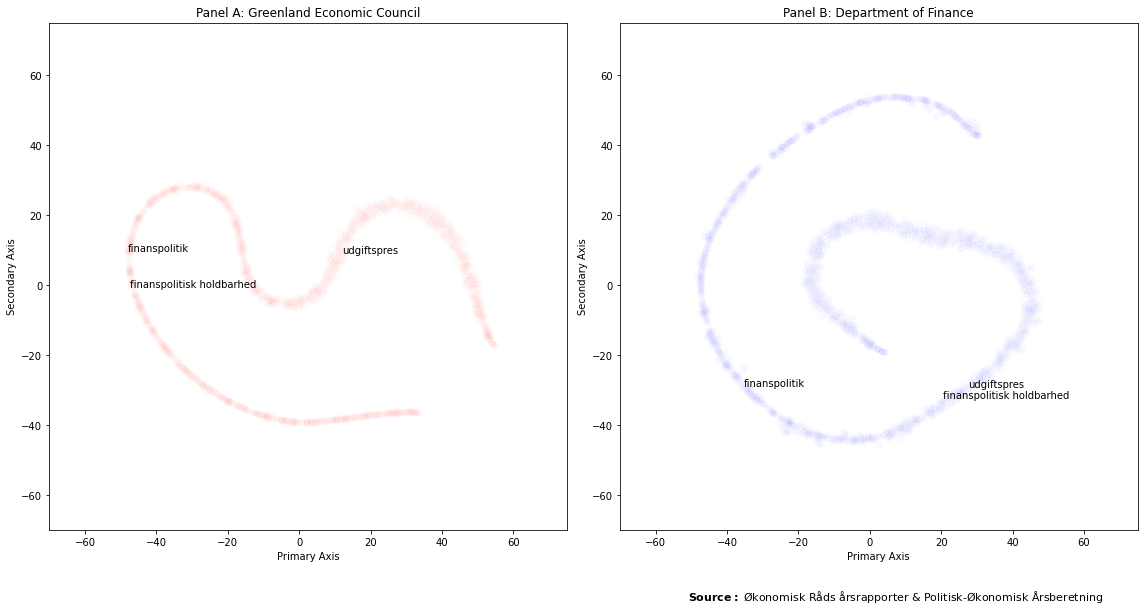

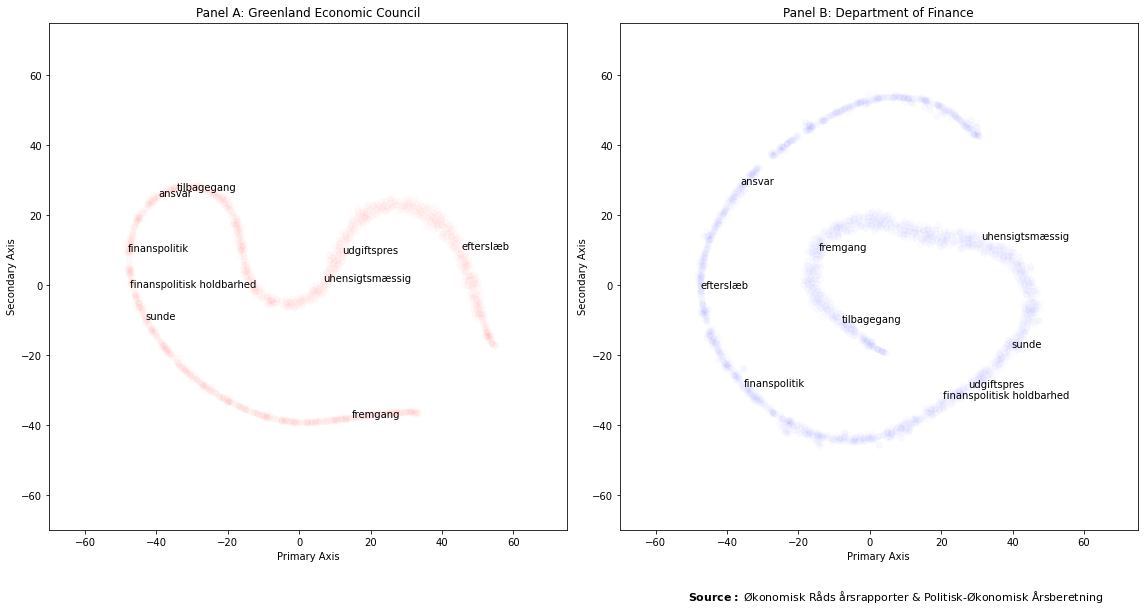

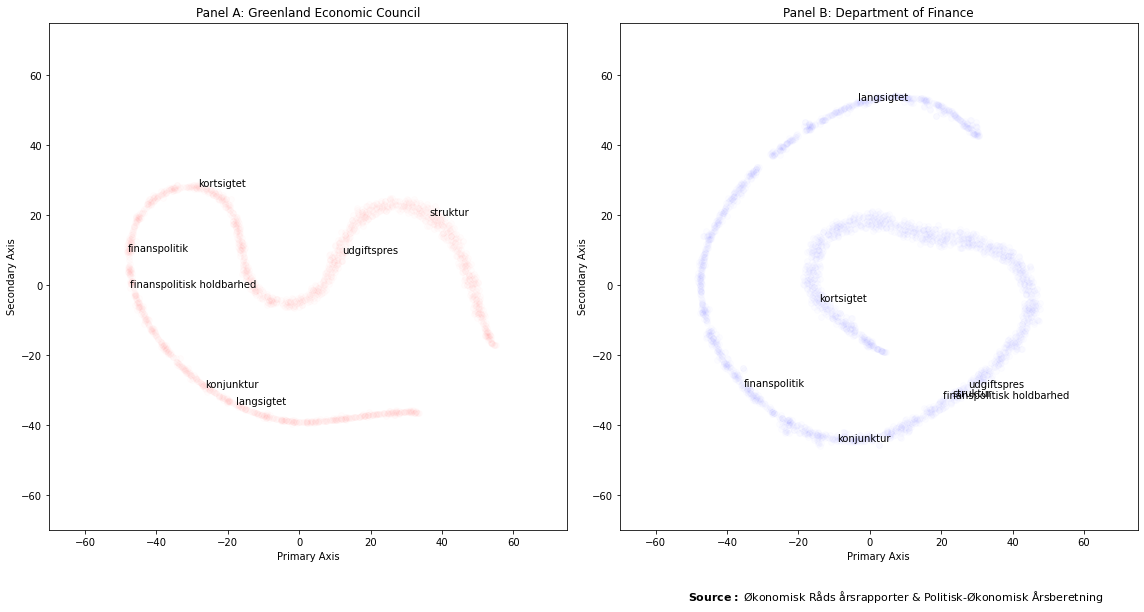

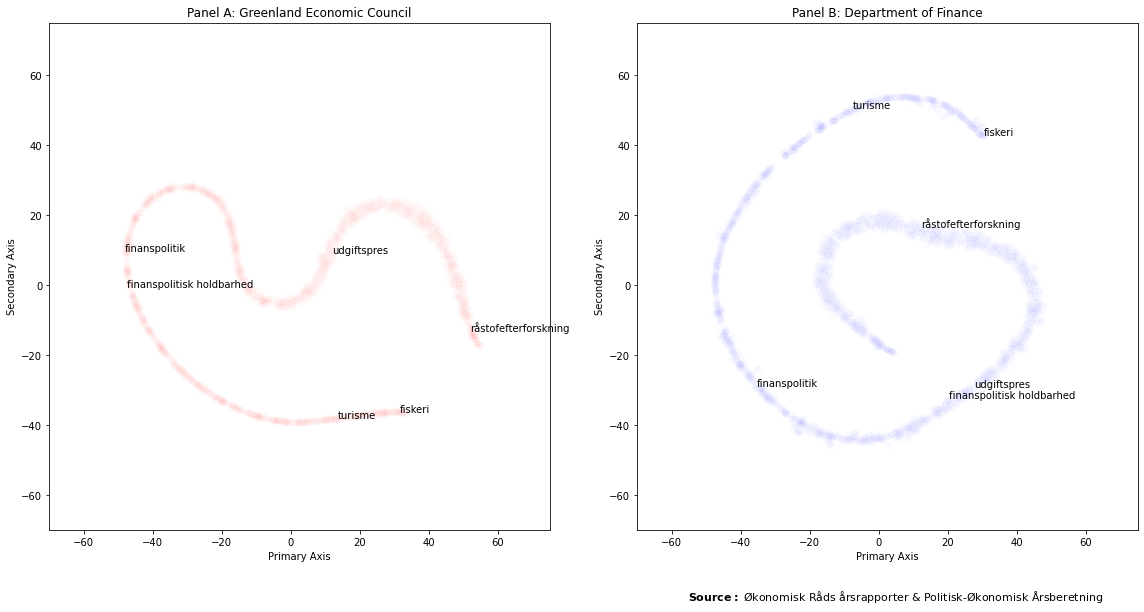

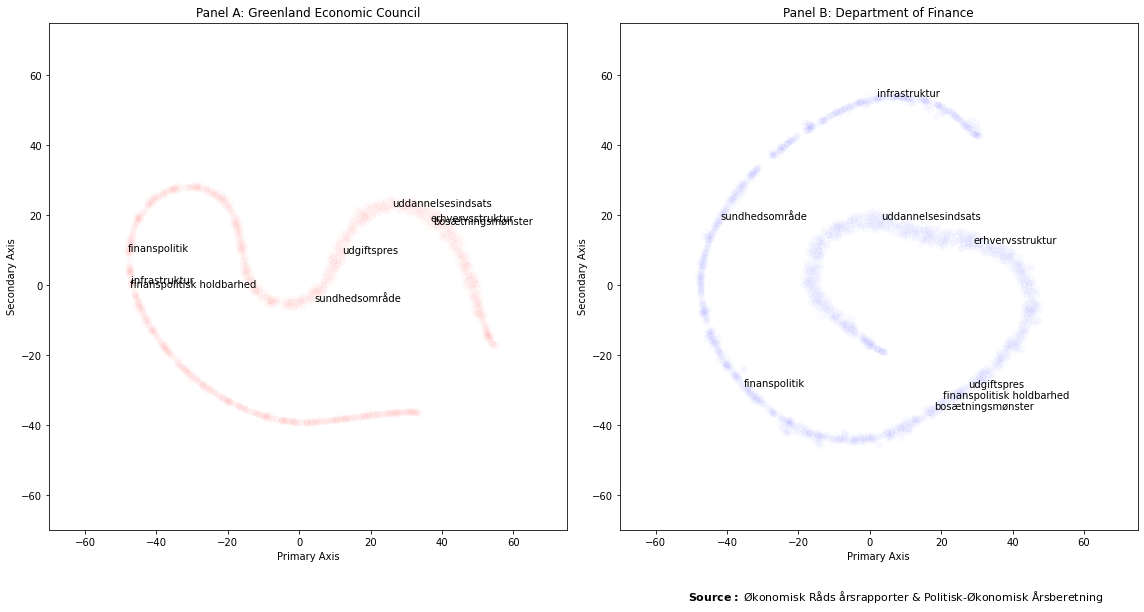

In [14]:
def make_plot(keywords, name, dpi = 200):
    
    """
    makes horizontal subplot for word embeddings.
    """

    # canvas
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 8)) # fun: subplot_kw = dict(projection = 'polar')
    
    # geoms
    axes[0].scatter(x_GEC, y_GEC, alpha = 0.01, color = "red")  # left plot, GEC
    axes[1].scatter(x_POB, y_POB, alpha = 0.01, color = "blue") # right plot, POB
    
    # GEC annotations
    labs_GEC = [labels_GEC.index(keyword) for keyword in keywords]             
    for i in labs_GEC: 
        axes[0].annotate(labels_GEC[i], (x_GEC[i], y_GEC[i]))
    
    # POB annotations
    labs_POB = [labels_POB.index(keyword) for keyword in keywords]            
    for i in labs_POB: 
        axes[1].annotate(labels_POB[i], (x_POB[i], y_POB[i]))
        
    """
    # fig title
    fig.suptitle(
        t = 'Figure 1: Plot of themes Fiscal and Assessment', 
        x = 0.05, 
        y = 1,
        fontsize   = 15,
        fontweight = 'bold',
        horizontalalignment = 'left', 
    )
    """
    
    # suptitles 
    actors = ["Panel A: Greenland Economic Council", "Panel B: Department of Finance"]
    for ax, actor in enumerate(actors): 
        axes[ax].set_title(actor)
    
    # ax labels 
    for ax in axes:
        ax.set_xlabel('Primary Axis')
        ax.set_ylabel('Secondary Axis')
        
    # caption
    plt.figtext(
        x = 0.6, 
        y = -0.05, 
        s = r"$\bf{Source:}$ Økonomisk Råds årsrapporter & Politisk-Økonomisk Årsberetning",
        horizontalalignment = 'left', 
        fontsize            = 11,
        wrap                = True, 
    ) 
    
    # adjustments
    plt.setp(axes, xlim = (-70, 75), ylim = (-70, 75))
    fig.tight_layout();
    
    plt.savefig(
        name, 
        bbox_inches = 'tight', 
        dpi         = dpi
    )
    
# common words
GEC_keys    = GEC_model.wv.index_to_key
POB_keys    = POB_model.wv.index_to_key
common_keys = set(GEC_keys).intersection(POB_keys) # search list for common words

# themes
finance     = ["finanspolitisk holdbarhed", "finanspolitik", "udgiftspres"]
assessment  = ["fremgang", "tilbagegang", "sunde", "uhensigtsmæssig", "ansvar", "efterslæb"]
time        = ["langsigtet", "kortsigtet", "konjunktur", "struktur"]
business    = ["råstofefterforskning", "fiskeri", "turisme"]
trends      = ["uddannelsesindsats", "erhvervsstruktur", "bosætningsmønster", "infrastruktur", "sundhedsområde"]

# comparing themes
theme0 = finance
theme1 = finance + assessment
theme2 = finance + time
theme3 = finance + business
theme4 = finance + trends

# plots in a loop
themes    = [theme0, theme1, theme2, theme3, theme4]
fig_names = ["fig" + str(num) + ".png" for num in range(len(themes))]

for theme, fig_name in zip(themes, fig_names):
    make_plot(theme, fig_name, dpi = "figure")

## Save data for documentation and clean working directory

In [16]:
# working directory
path = os.getcwd()

# path for new folders
raw_path  = path + "\\raw"
fig_path  = path + "\\viz"
data_path = path + "\\data"

# make new folders
os.mkdir(fig_path)
os.mkdir(raw_path)
os.mkdir(data_path)

# move reports to raw-foder
reports = GEC_files + POB_files
for report in reports:
    shutil.move(report, raw_path)

# move figures to viz-folder    
figures = fig_names + ["table_count", "table_themes"]
for figure in figures:
    shutil.move(figure, fig_path)

# data in pandas dataframe
GEC = pd.DataFrame(list(zip(labels_GEC, x_GEC, y_GEC)), columns = ["label", "x", "y"])
POB = pd.DataFrame(list(zip(labels_POB, x_POB, y_POB)), columns = ["label", "x", "y"])

# path for storing data
GEC_path = data_path + "\\GEC.csv"
POB_path = data_path + "\\POB.csv"

# save dataframes as csv files
GEC.to_csv(GEC_path)
POB.to_csv(POB_path)

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

## Kill Your Darlings

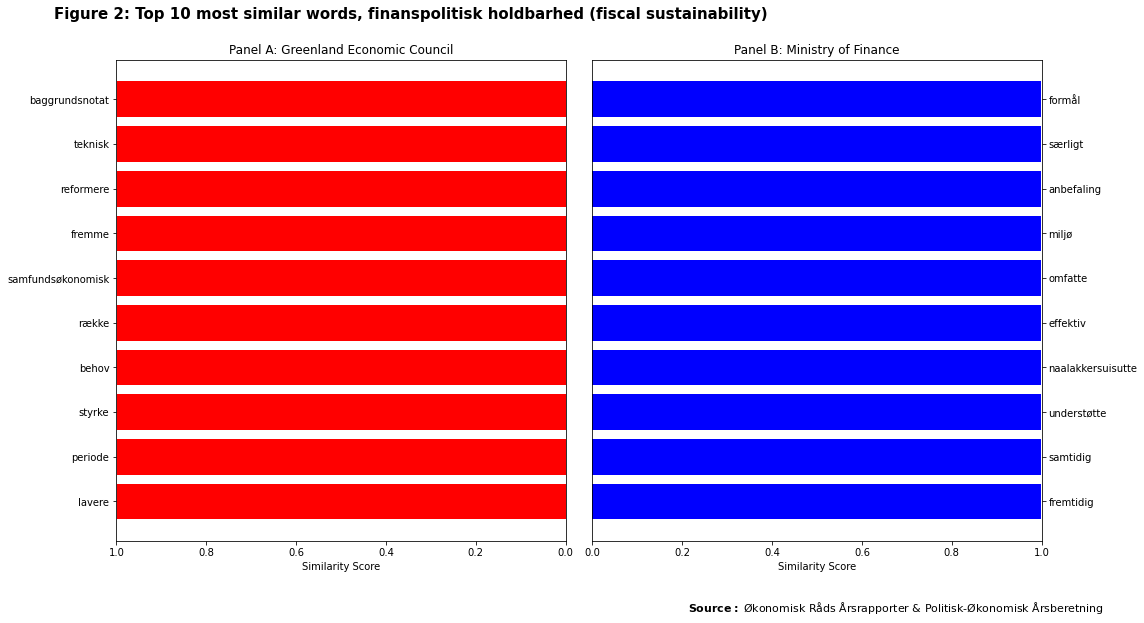

In [36]:
# data (top 10 similarity, finanspolitik) 
key = "finanspolitisk holdbarhed"

df_GEC = \
    pd.DataFrame(
        GEC_model.wv.most_similar(key, topn = 10), 
        columns = ["word", "similarity"]
)

df_POB = \
    pd.DataFrame(
        POB_model.wv.most_similar(key, topn = 10), 
        columns = ["word", "similarity"]
)

# canvas 
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 8)) # fun: subplot_kw = dict(projection = 'polar')

# geoms
axes[0].barh(df_GEC.word, df_GEC.similarity, color = "red")
axes[1].barh(df_POB.word, df_POB.similarity, color = "blue")

# descending order
axes[0].invert_yaxis()
axes[1].invert_yaxis()

# fig title
fig.suptitle(
    t = f'Figure 2: Top 10 most similar words, {key} (fiscal sustainability)', 
    x = 0.05, 
    y = 1,
    fontsize   = 15,
    fontweight = 'bold',
    horizontalalignment = 'left', 
)

# suptitles 
actors = ["Panel A: Greenland Economic Council", "Panel B: Ministry of Finance"]
for ax, actor in enumerate(actors): 
    axes[ax].set_title(actor)
    
# ax labels 
for ax in axes:
    ax.set_xlabel('Similarity Score')
    ax.set_ylabel('')

# caption
plt.figtext(
    x = 0.6, 
    y = -0.05, 
    s = r"$\bf{Source:}$ Økonomisk Råds Årsrapporter & Politisk-Økonomisk Årsberetning",
    horizontalalignment = 'left', 
    fontsize            = 11,
    wrap                = True, 
) 

# right plot, right y ticks 
axes[1].yaxis.tick_right()

# limits
axes[0].set_xlim([1, 0]) # invert scale
axes[1].set_xlim([0, 1]);

# adjustment
fig.tight_layout();

In [37]:
# keywords
w1, w2 = "finanspolitisk holdbarhed", "finanspolitik"

# table
secondTable = PrettyTable()

# title
secondTable.title = f'Keywords: "{w1}" and "{w2}"'

# columns 
secondTable.field_names = ["Agent", "Similarity", "Distance"]

# cells 
GEC_sim  = round(GEC_model.wv.similarity(w1, w2), 3)
POB_sim  = round(POB_model.wv.similarity(w1, w2), 3)
GEC_dist = round(GEC_model.wv.distance(w1, w2), 3)
POB_dist = round(POB_model.wv.distance(w1, w2), 3)

# rows 
secondTable.add_row(["Greenland Economic Council", GEC_sim, GEC_dist])
secondTable.add_row(["Department of Finance", POB_sim, POB_dist])

# alignment
secondTable.align["Agent"] = "l"

print(secondTable)

+-------------------------------------------------------------+
|  Keywords: "finanspolitisk holdbarhed" and "finanspolitik"  |
+---------------------------------+--------------+------------+
| Agent                           |  Similarity  |  Distance  |
+---------------------------------+--------------+------------+
| Greenland Economic Council      |    0.999     |   0.001    |
| Ministy of Finance              |    0.998     |   0.002    |
+---------------------------------+--------------+------------+
